In [2]:
from collections import defaultdict
import logging
from typing import cast, Dict, List, Tuple, Union, Callable
from typing_extensions import get_args, Literal
import sys
import os
import numpy as np
import random 
import seaborn as sns
from PIL import Image
import re
from scipy.stats import spearmanr
from matplotlib.legend_handler import HandlerLine2D
import torch
import torch.nn as nn
import torch.nn.functional as F
import json

import yaml
import argparse
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial

from torch.utils.data import DataLoader, TensorDataset

sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments/utils')
sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments')

from aheads import create_repeats_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
from transformers import BertConfig, BertForMaskedLM, AdamW

import matplotlib.style as style
style.use('ggplot')

from toy_model import TrainingPipeline
from utils.toy_utils import bin_train_loop, create_dataloaders_bin, Probe, POSVocabGenerator, plot_pca_embeddings
from utils.forgetting_utils import AdamEF
from dataclasses import dataclass, field

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

/users/sanand14/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /oscar/home/sanand14/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


[2024-09-28 15:41:24,877] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


vocab size 10,000, amb 0.10, unif, stop forgetting after 20000

In [3]:
sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 2})

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Config, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import random
import numpy as np
from dataclasses import dataclass, field
from typing import List, Callable
from tqdm import tqdm

In [5]:

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

@dataclass
class ICLVocabGenerator:
    tokens: List[int] = field(default_factory=list)
    random_tokens: List[int] = field(default_factory=list)
    a: float = 1.5
    bins: int = 10
    sample_func: str = 'zipfian'
    token_label_map: dict = field(default_factory=dict)  # Mapping from tokens to labels
    label_tokens: dict = field(default_factory=dict)     # Tokens representing labels
    vocab_size: int = 0  # Total vocabulary size including special tokens

    def parameterize_icl_vocab(self, num_icl_tokens: int, num_random_tokens: int, bins=10, a=1.0001, sample_func='zipfian'):
        """
        Initialize the vocabulary and token-label mappings.
        """
        # Use integer tokens
        self.tokens = list(range(num_icl_tokens))
        self.random_tokens = list(range(num_icl_tokens, num_icl_tokens + num_random_tokens))
        self.a = a
        self.bins = bins
        self.sample_func = sample_func

        # Create token to label mapping (1:1 mapping)
        self.token_label_map = {}
        self.label_tokens = {}
        label_token_start = num_icl_tokens + num_random_tokens  # Starting index for label tokens
        for idx, token in enumerate(self.tokens):
            label = idx  # Unique label for each token
            label_token = label_token_start + idx
            self.token_label_map[token] = label
            self.label_tokens[label] = label_token
                ## multiplicity of possible labels
        
        # Reserve IDs for evaluation label tokens (0 and 1)
        self.eval_label_tokens = {
            0: label_token_start,
            1: label_token_start + 1
        }

        # Define special tokens
        self.eos_token_id = label_token_start + len(self.tokens)
        self.pad_token_id = label_token_start + len(self.tokens) + 1

        # Update total vocabulary size
        self.vocab_size = self.pad_token_id + 1  # Include all tokens up to PAD token

    def _uniform(self, tokens):
        return random.choice(tokens)

    def uniform(self):
        return self._uniform(self.tokens)

    def _zipfian(self, tokens):
        token_map = {k + 1: v for k, v in enumerate(tokens)}
        while True:
            value = np.random.zipf(self.a)
            if value in token_map:
                return token_map[value]

    def zipfian(self):
        return self._zipfian(self.tokens)
    
    def create_dataset_task_icl(self, num_examples: int, sample_func: Callable = None, bursty_ratio: float = 0.0) -> List[List[int]]:
        """
        Generate training dataset with sequences sampled from sample_func distribution.
        Each sequence ends with a query token and its label.
        In 'bursty' sequences, the query class appears 3 times in the context,
        and another class also appears 3 times.
        Parameters:
            num_examples (int): Total number of sequences to generate.
            sample_func (Callable): Function to sample tokens from the token distribution.
            bursty_ratio (float): Proportion of sequences that should be bursty (between 0 and 1).
        Returns:
            List[List[int]]: A list of sequences, each sequence is a list of token IDs.
        """
        dataset = []
        if sample_func is None:
            sample_func = self.zipfian  
    
        num_bursty = int(num_examples * bursty_ratio)
        num_non_bursty = num_examples - num_bursty
        # print(num_bursty)
        for _ in tqdm(range(num_bursty)):
            seq = []
            query_token = sample_func()
            other_tokens = [token for token in self.tokens if token != query_token]
            if not other_tokens:
                raise ValueError("Not enough tokens to create bursty sequences with two classes.")
            non_query_tokens = random.choices(other_tokens, k=3)
            token_counts = {query_token: 3, non_query_tokens[0]: 3, non_query_tokens[1]: 1, non_query_tokens[2]: 1}
            labels = {}
            for token in token_counts.keys():
                if random.random() > 0.90:
                    labels[token] = random.choice([0, 1])
                else:
                    labels[token] = self.token_label_map[token]
            context_examples = []
            for token, count in token_counts.items():
                label = labels[token]
                # print(label)
                label_token = self.label_tokens[label]
                for _ in range(count):
                    context_examples.append([token, label_token])
            random.shuffle(context_examples)
            for example in context_examples:
                seq.extend(example)
                
            query_label = labels[query_token]
            query_label_token = self.label_tokens[query_label]
            seq.extend([query_token, query_label_token])
            dataset.append(seq)
    
        for _ in range(num_non_bursty):
            seq = []
            for _ in range(8):
                token = sample_func()
                label = random.choice(self.token_label_map[token])
                label_token = self.label_tokens[label]
                seq.extend([token, label_token])
    
            query_token = sample_func()
            query_label = random.choice(self.token_label_map[query_token])
            query_label_token = self.label_tokens[query_label]
            seq.extend([query_token, query_label_token])
            dataset.append(seq)
    
        random.shuffle(dataset)
    
        return dataset

    def create_eval_dataset_in_context(self, num_examples: int, holdout=False) -> List[List[int]]:
        """
        Generate evaluation dataset for in-context learning on holdout tokens.
        Each sequence consists of context examples from 2 holdout classes (tokens not seen during training),
        with 4 examples each (total 8 examples). Labels for the two classes are randomly assigned to 0 and 1
        for each sequence. The query is randomly selected from one of the two classes.
        """
        dataset = []
        if holdout:
            holdout_tokens = self.random_tokens.copy()  # Tokens not used during training
        else:
            holdout_tokens = self.tokens.copy()
    
        for _ in range(num_examples):
            seq = []
            if holdout:
                query_token = random.choice(holdout_tokens)
                other_tokens = [token for token in holdout_tokens if token != query_token]
            else:
                query_token = sample_func()
                other_tokens = [token for token in self.tokens if token != query_token]
            if not other_tokens:
                raise ValueError("Not enough tokens to create bursty sequences with two classes.")
            non_query_tokens = random.choices(other_tokens, k=3)
            token_counts = {query_token: 4, non_query_tokens[0]: 4, non_query_tokens[1]: 0, non_query_tokens[2]: 0}
            labels = {query_token: random.choice([0, 1]), 
                      non_query_tokens[0]: random.choice([0, 1]), 
                      non_query_tokens[1]: random.choice([0, 1]), 
                      non_query_tokens[2]: random.choice([0, 1])}

            context_examples = []
            for token, count in token_counts.items():
                label = labels[token]

                label_token = self.label_tokens[label]
                for _ in range(count):
                    context_examples.append([token, label_token])
            random.shuffle(context_examples)
            for example in context_examples:
                seq.extend(example)
                
            query_label = labels[query_token]
            query_label_token = self.label_tokens[query_label]
            seq.extend([query_token, query_label_token])
            dataset.append(seq)
        return dataset

    def create_eval_dataset_in_weights(self, num_examples: int) -> List[List[int]]:
        """
        Generate evaluation dataset for in-weights learning.
        Sequences have labels same as in training, but the query token does not appear in the context.
        The model must use information stored in weights to predict the query label.
        """
        dataset = []
        training_tokens = self.tokens
        for _ in range(num_examples):
            seq = []

            context_tokens = random.sample(training_tokens, k=8)
            query_token = random.choice([t for t in training_tokens if t not in context_tokens])
            for token in context_tokens:
                label = self.token_label_map[token]
                label_token = self.label_tokens[label]
                seq.extend([token, label_token])

            query_label = self.token_label_map[query_token]
            query_label_token = self.label_tokens[query_label]
            seq.extend([query_token, query_label_token])
            dataset.append(seq)
        return dataset

In [6]:
class CustomSequenceDataset(Dataset):
    def __init__(self, sequences, eos_token_id, pad_token_id, block_size=17):
        self.examples = []
        self.block_size = block_size
        self.eos_token_id = eos_token_id
        self.pad_token_id = pad_token_id
        for seq in sequences:
            # Truncate or pad to block_size
            seq = seq[:self.block_size]  # Leave space for <EOS>
            # seq.append(self.eos_token_id)  # Append <EOS> token
            padding_length = self.block_size - len(seq)
            input_ids = seq + ([self.pad_token_id] * padding_length)  # Pad with <PAD> token

            # Prepare attention_mask
            attention_mask = [1] * len(seq) + [0] * padding_length

            # Prepare labels
            labels = [-100] * self.block_size
            # labels = seq[1:] + [self.eos_token_id] + (padding_length)*[-100]

            # Identify the position of the query label
            seq_length = len(seq)
            # print(seq_len)
            # if seq_length >= 3:
                # The position of the query label is seq_length - 2 (before EOS token)
            query_label_pos = seq_length - 2
            labels[query_label_pos] = input_ids[query_label_pos+1]

            self.examples.append({
                'input_ids': input_ids,
                'labels': labels,
                'attention_mask': attention_mask
            })

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        item = self.examples[i]
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
            'labels': torch.tensor(item['labels'], dtype=torch.long),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long)
        }


In [7]:
# Initialize the vocabulary generator
vocab_gen = ICLVocabGenerator()
num_icl_tokens = 2000
num_random_tokens = 200
bursty_ratio = 1.0
sample_func=vocab_gen.uniform
vocab_gen.parameterize_icl_vocab(num_icl_tokens=num_icl_tokens, num_random_tokens=num_random_tokens)

# Generate training data
num_train_examples = 100000
num_test_examples = 2000
train_sequences = vocab_gen.create_dataset_task_icl(num_examples=num_train_examples, 
                                                    sample_func=sample_func, 
                                                    bursty_ratio=bursty_ratio)
val_sequences = vocab_gen.create_dataset_task_icl(num_examples=num_test_examples, 
                                                    sample_func=sample_func, 
                                                    bursty_ratio=bursty_ratio)
eval_sequences_in_context = vocab_gen.create_eval_dataset_in_context(num_examples=num_test_examples)
eval_sequences_in_context_holdout = vocab_gen.create_eval_dataset_in_context(num_examples=num_test_examples, holdout=True)
eval_sequences_in_weights = vocab_gen.create_eval_dataset_in_weights(num_examples=num_test_examples)

# Create datasets
block_size = 18  # Adjust as needed
train_dataset = CustomSequenceDataset(train_sequences, 
                                      eos_token_id=vocab_gen.eos_token_id, 
                                      pad_token_id=vocab_gen.pad_token_id, 
                                      block_size=block_size)
val_dataset = CustomSequenceDataset(val_sequences, 
                                      eos_token_id=vocab_gen.eos_token_id, 
                                      pad_token_id=vocab_gen.pad_token_id, 
                                      block_size=block_size)
eval_dataset_in_context = CustomSequenceDataset(eval_sequences_in_context, 
                                                eos_token_id=vocab_gen.eos_token_id, 
                                                pad_token_id=vocab_gen.pad_token_id, 
                                                block_size=block_size)
eval_dataset_in_context_holdout = CustomSequenceDataset(eval_sequences_in_context_holdout, 
                                                eos_token_id=vocab_gen.eos_token_id, 
                                                pad_token_id=vocab_gen.pad_token_id, 
                                                block_size=block_size)
eval_dataset_in_weights = CustomSequenceDataset(eval_sequences_in_weights, 
                                                eos_token_id=vocab_gen.eos_token_id, 
                                                pad_token_id=vocab_gen.pad_token_id, 
                                                block_size=block_size)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
eval_loader_in_context = DataLoader(eval_dataset_in_context, batch_size=batch_size)
eval_loader_in_context_holdout = DataLoader(eval_dataset_in_context_holdout, batch_size=batch_size)
eval_loader_in_weights = DataLoader(eval_dataset_in_weights, batch_size=batch_size)



100%|█████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 12620.73it/s]


In [8]:
val_dataset[0]

{'input_ids': tensor([ 831, 3031,  535, 2735,  399, 2599,  825, 3025,  399, 2599,  535, 2735,
          535, 2735,  399, 2599,  535, 2735]),
 'labels': tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, 2735, -100]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [9]:
eval_dataset_in_context[0]

{'input_ids': tensor([1214, 2200, 1490, 2201, 1490, 2201, 1490, 2201, 1490, 2201, 1214, 2200,
         1214, 2200, 1214, 2200, 1490, 2201]),
 'labels': tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, 2201, -100]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [60]:
train_dataset[0]

{'input_ids': tensor([ 893, 1801,  574, 2374,  742, 2542,  742, 2542,  484, 2284,  574, 2374,
          574, 2374,  742, 2542,  574, 2374]),
 'labels': tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, 2374, -100]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [61]:
in_context_accuracy = evaluate_in_context(
            model, eval_loader_in_context, device, vocab_gen.eval_label_tokens)


In [62]:
in_weights_accuracy = evaluate(model, eval_loader_in_weights, device)

In [63]:
in_weights_accuracy

0.7445

In [64]:
in_context_accuracy

0.7305

In [65]:
evaluate(model, val_loader, device)

0.992

In [66]:
idx = 9

inputs = eval_dataset_in_context[idx]['input_ids'].to(device).unsqueeze(0)
labels = eval_dataset_in_context[idx]['labels'].to(device).unsqueeze(0)
attention_mask = eval_dataset_in_context[idx]['attention_mask'].to(device).unsqueeze(0)

print(inputs, labels, model(input_ids = inputs, attention_mask=attention_mask).logits.argmax(-1))

tensor([[ 900, 1801,  900, 1801,  900, 1801,    4, 1801,    4, 1801,    4, 1801,
          900, 1801,    4, 1801,    4, 1801]], device='cuda:0') tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, 1801, -100]], device='cuda:0') tensor([[1814, 1801, 1937, 1801, 1987, 1801, 1801, 1801, 1819, 1801, 1801, 1801,
         1803, 1801, 1801, 1801, 1801, 1801]], device='cuda:0')


In [67]:
idx = 17

inputs = train_dataset[idx]['input_ids'].to(device).unsqueeze(0)
labels = train_dataset[idx]['labels'].to(device).unsqueeze(0)
attention_mask = train_dataset[idx]['attention_mask'].to(device).unsqueeze(0)

print(inputs, labels, model(input_ids = inputs, attention_mask=attention_mask).logits.argmax(-1))

tensor([[ 660, 2460,  510, 1801, 1321, 3121,  510, 1801, 1321, 3121, 1321, 3121,
          608, 2408,  510, 1801, 1321, 3121]], device='cuda:0') tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, 3121, -100]], device='cuda:0') tensor([[1814, 1842, 1937, 1801, 1987, 3121, 2357, 1801, 2436, 3121, 1801, 3121,
         1809, 2408, 1801, 1801, 3121, 3121]], device='cuda:0')


In [93]:
import torch.nn.functional as F


# Initialize the GPT-2 model from scratch
# Initialize GPT-2 configuration
config = GPT2Config(
    vocab_size=vocab_gen.vocab_size,
    n_positions=block_size,
    n_ctx=block_size,
    n_embd=64,   # Reduced for faster training; adjust as needed
    n_layer=4,    # Reduced number of layers
    n_head=4      # Adjusted number of heads
)

# Initialize GPT-2 model from scratch
model = GPT2LMHeadModel(config)

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)  # Higher learning rate for training from scratch

# Total number of training epochs
num_epochs = 8
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps//10, num_training_steps=total_steps)

loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)

In [94]:
embedding_matrix_init = model.get_input_embeddings()
embedding_matrix_init = list(embedding_matrix_init.parameters())[0].data

In [97]:
metrics4 = train(model, train_loader, optimizer, scheduler, device, num_epochs)

0.5105 0.5325 0.0
0.5175 0.5375 0.0
0.5395 0.561 0.001
0.6135 0.608 0.001
0.616 0.5985 0.0005
0.666 0.648 0.0005
0.715 0.705 0.0005
0.7415 0.739 0.0005
0.7515 0.749 0.0005
Epoch [1/8], Step [1000/6250], Loss: 8.2583
0.7485 0.7425 0.0005
0.7495 0.7405 0.0005
0.755 0.7475 0.0005
0.756 0.7475 0.0005
0.752 0.7465 0.0005
0.752 0.75 0.0005
0.755 0.7535 0.0005
0.755 0.75 0.001
0.753 0.753 0.0005
0.757 0.7525 0.0005
Epoch [1/8], Step [2000/6250], Loss: 8.1366
0.761 0.756 0.001
0.7585 0.756 0.0015
0.757 0.7485 0.001
0.7545 0.7505 0.003
0.75 0.745 0.0035
0.7565 0.7445 0.004
0.7565 0.7455 0.006
0.754 0.7445 0.005
0.75 0.7455 0.0025
0.7555 0.744 0.0055
Epoch [1/8], Step [3000/6250], Loss: 7.9955
0.747 0.748 0.007
0.754 0.742 0.0085
0.7585 0.7435 0.0065
0.753 0.748 0.0075
0.751 0.7435 0.0045
0.7475 0.7435 0.0065
0.75 0.7455 0.006
0.7485 0.7445 0.0085
0.7535 0.7445 0.0075
0.751 0.7435 0.0075
Epoch [1/8], Step [4000/6250], Loss: 7.8393
0.744 0.744 0.014
0.7475 0.7485 0.0135
0.7285 0.744 0.0075
0.741 

In [98]:
with open('metrics4.json', 'w') as f:
    json.dump(metrics4, f)

In [100]:
## 100,000 examples, 8 epochs, 4 layers, 0.05 amb, 1600 

metrics4['unseen'] = metrics4['holdout']
del metrics4['holdout']

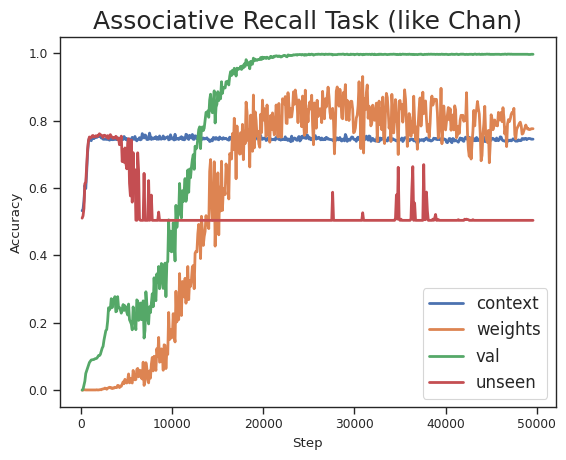

In [101]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for k, v in metrics4.items():
    ax.plot(range(100, 100*len(v)+100, 100), v, label=k)
plt.legend(fontsize=12)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Associative Recall Task (like Chan)', fontsize=18)
plt.show()

In [107]:
metrics_path = '/users/sanand14/data/sanand14/learning_dynamics/outputs/toy_model_ar/amb_0.05-numtr_100000-a_1.0001/hist.csv'
metrics5 = pd.read_csv(metrics_path)

In [108]:
metrics5 = metrics5[['context','weights','holdout','val']]

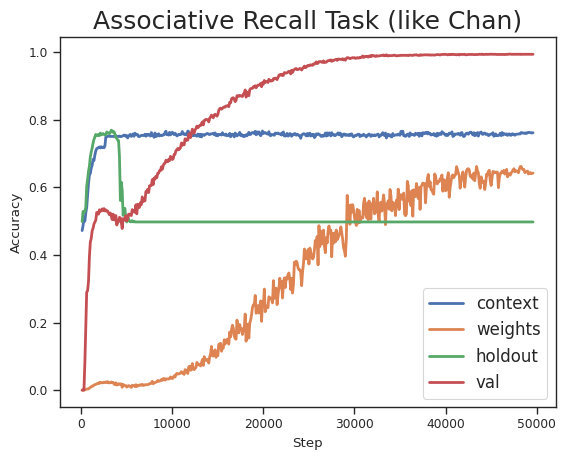

In [109]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for c in metrics5.columns:
    ax.plot(range(100, 100*len(v)+100, 100), metrics5[c], label=c)
plt.legend(fontsize=12)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Associative Recall Task (like Chan)', fontsize=18)
plt.show()

1. Structural ICL is Transient (NL)
3. Structural ICL is not Conditional ICL -- Specifically, tail behavior (references magikarp)
4. Active Forgetting
5. Temporary Forgetting

In [10]:
import torch.nn.functional as F
from utils.forgetting_utils import AdamEF


# Initialize the GPT-2 model from scratch
# Initialize GPT-2 configuration
config = GPT2Config(
    vocab_size=vocab_gen.vocab_size,
    n_positions=block_size,
    n_ctx=block_size,
    n_embd=64,   # Reduced for faster training; adjust as needed
    n_layer=4,    # Reduced number of layers
    n_head=4      # Adjusted number of heads
)

# Initialize GPT-2 model from scratch
model2 = GPT2LMHeadModel(config)

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

# Define optimizer and schedu
num_epochs = 8
total_steps = len(train_loader) * num_epochs

optimizer = AdamEF(model2.parameters(), lr=5e-5, lr_emb=5e-5, weight_decay=0.01, clear_embed_every_K_updates=1000)
optimizer.stop_after = 10000000
optimizer.embed_offset = list(filter(lambda p: p.requires_grad, model2.parameters()))[0].numel()

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps//10, num_training_steps=total_steps)

loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100)

In [19]:
metrics38= train(model2, train_loader, optimizer, scheduler, device, num_epochs)


0.538 0.511 0.0
0.565 0.53 0.0
0.6025 0.5695 0.0
0.6515 0.6225 0.0
0.577 0.5605 0.0
0.666 0.6395 0.0
0.667 0.6425 0.0
0.6685 0.637 0.0
0.659 0.6245 0.0
Clearing embeddings at step 1000
Epoch [1/8], Step [1000/6250], Loss: 41.3711
0.518 0.5115 0.0
0.504 0.485 0.001
0.505 0.4825 0.001
0.504 0.4825 0.0005
0.504 0.4825 0.0
0.504 0.4825 0.0
0.504 0.4825 0.0
0.504 0.4825 0.0
0.505 0.4825 0.0
0.504 0.489 0.0
Clearing embeddings at step 2000
Epoch [1/8], Step [2000/6250], Loss: 30.8403
0.5045 0.4825 0.0005
0.5045 0.4825 0.0
0.5045 0.4825 0.001
0.5045 0.4825 0.0
0.504 0.4825 0.0005
0.5045 0.4825 0.0005
0.504 0.4825 0.0
0.5225 0.5035 0.0
0.525 0.5045 0.0
0.5285 0.5155 0.0
Clearing embeddings at step 3000
Epoch [1/8], Step [3000/6250], Loss: 26.9601
0.5045 0.484 0.0
0.5045 0.484 0.0
0.5045 0.484 0.0005
0.5045 0.484 0.0
0.5045 0.4835 0.0
0.504 0.4835 0.0
0.504 0.4835 0.0
0.504 0.4835 0.0
0.504 0.483 0.0
0.5075 0.484 0.0005
Clearing embeddings at step 4000
Epoch [1/8], Step [4000/6250], Loss: 24.90

In [24]:
metrics38= train(model2, train_loader, optimizer, scheduler, device, 4)


0.743 0.742 0.0005
0.745 0.743 0.0005
0.747 0.743 0.0005
0.7485 0.74 0.0005
0.743 0.7485 0.0005
0.7515 0.7405 0.0005
0.742 0.7495 0.0005
0.744 0.7505 0.0005
0.7435 0.751 0.0005
Clearing embeddings at step 1000
Epoch [1/4], Step [1000/6250], Loss: 2.8082
0.75 0.743 0.0005
0.7445 0.7445 0.0005
0.7435 0.7425 0.0
0.749 0.7445 0.0
0.7455 0.7455 0.0005
0.747 0.745 0.0
0.7495 0.7425 0.0
0.75 0.7425 0.0
0.746 0.7395 0.0
0.7535 0.74 0.0
Clearing embeddings at step 2000
Epoch [1/4], Step [2000/6250], Loss: 2.8180
0.7585 0.744 0.0
0.7665 0.7425 0.0
0.766 0.7515 0.0
0.765 0.7475 0.0
0.7635 0.7415 0.0
0.7635 0.75 0.0
0.7695 0.7485 0.0
0.7675 0.747 0.0
0.7665 0.747 0.0
0.743 0.742 0.0
Clearing embeddings at step 3000
Epoch [1/4], Step [3000/6250], Loss: 2.8152
0.743 0.744 0.0
0.7455 0.7415 0.0
0.7425 0.738 0.0
0.7475 0.7425 0.0
0.746 0.7415 0.0
0.7465 0.741 0.0
0.7465 0.7405 0.0
0.742 0.7445 0.0
0.749 0.7385 0.0
0.749 0.7405 0.0
Clearing embeddings at step 4000
Epoch [1/4], Step [4000/6250], Loss: 2

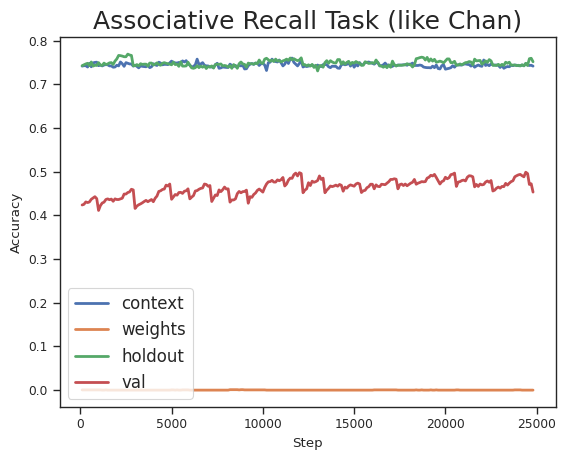

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for k, v in metrics38.items():
    ax.plot(range(100, 100*len(v)+100, 100), v, label=k)
plt.legend(fontsize=12)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Associative Recall Task (like Chan)', fontsize=18)
plt.show()

In [12]:
def evaluate_in_context(model, dataloader, device, eval_label_tokens):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    label_token_to_label = {v: k for k, v in eval_label_tokens.items()}  # Map label tokens to labels 0 or 1
    label_token_ids = torch.tensor([eval_label_tokens[0], eval_label_tokens[1]]).to(device)
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)  # Contains the query labels at the appropriate positions
            # print(inputs, labels)

            # Forward pass
            outputs = model(inputs, attention_mask=attention_mask)
            logits = outputs.logits  # Shape: (batch_size, seq_len, vocab_size)

            # Get the positions where labels are not -100 (i.e., the query label positions)
            label_mask = labels != -100  # Shape: (batch_size, seq_len)

            if label_mask.any():
                batch_size, seq_len, vocab_size = logits.size()
                label_positions = label_mask.nonzero(as_tuple=False)
                for idx in range(label_positions.size(0)):
                    batch_idx, pos = label_positions[idx]
                    logits_at_pos = logits[batch_idx, pos, :] 
                    logits_for_labels = logits_at_pos[label_token_ids] 
                    predicted_label_idx = torch.argmax(logits_for_labels).item()
                    predicted_label = predicted_label_idx  # Since labels are 0 or 1
                    # Actual label token
                    actual_label_token = labels[batch_idx, pos].item()
                    actual_label = label_token_to_label[actual_label_token]
                    # Check if prediction is correct
                    if predicted_label == actual_label:
                        correct_predictions += 1
                    total_predictions += 1
                    # print(predicted_label)
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    # print(correct_predictions, total_predictions)
    
    model.train()
    return accuracy


In [85]:
evaluate_in_context(model, eval_loader_in_context, device, vocab_gen.eval_label_tokens)

0.911

In [86]:
evaluate_in_context(
            model, eval_loader_in_context, device, vocab_gen.eval_label_tokens
        )

0.911

In [18]:
def evaluate(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(inputs, attention_mask=attention_mask)
            logits = outputs.logits  # Shape: (batch_size, seq_len, vocab_size)

            # Get the positions where labels are not -100 (i.e., the query label positions)
            label_mask = labels != -100  # Shape: (batch_size, seq_len)

            if label_mask.any():
                predicted_tokens = torch.argmax(logits, dim=-1)  # Shape: (batch_size, seq_len)
                correct = (predicted_tokens == labels) & label_mask
                correct_predictions += correct.sum().item()
                total_predictions += label_mask.sum().item()

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    model.train()
    return accuracy

In [17]:
def train(model, train_loader, optimizer, scheduler, device, num_epochs):
    model.train()
    metrics = {'context': [], 'weights': [], 'holdout': [], 'val': []}
    for epoch in range(num_epochs):
        total_loss = 0
        for step, batch in enumerate(train_loader):
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids=inputs, attention_mask=attention_mask)
            logits = outputs.logits 
            
            logits = logits.view(-1, logits.size(-1))  # Shape: (batch_size * seq_len, vocab_size)
            labels = labels.view(-1)
            # print(logits.shape, labels.shape)
            loss = loss_fct(logits, labels)
            # Backward pass and optimization
            # print(loss)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

            if hasattr(optimizer, 'clear_embed_every_K_updates') and optimizer.clear_embed_every_K_updates > 0:
                if (isinstance(optimizer.clear_embed_every_K_updates, int) and (step+1) % optimizer.clear_embed_every_K_updates == 0):
                    if optimizer.stop_after is None or (isinstance(optimizer.stop_after, int) and (step+1) < optimizer.stop_after):
                        print(f"Clearing embeddings at step {(step+1)}", flush=True)
                        model2.transformer.wte.reset_parameters()
                        
            # Print loss every 100 steps or at the end of epoch
            if (step + 1) % 1000 == 0 or (step + 1) == len(train_loader):
                avg_loss = total_loss / (step + 1)
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Loss: {avg_loss:.4f}")
                
            if (step + 1) % 100 == 0:
                metrics['holdout'].append(evaluate_in_context(
                            model, eval_loader_in_context_holdout, device, vocab_gen.eval_label_tokens))
                metrics['context'].append(evaluate_in_context(
                            model, eval_loader_in_context, device, vocab_gen.eval_label_tokens))
                metrics['weights'].append(evaluate(model, eval_loader_in_weights, device))
                metrics['val'].append(evaluate(model, val_loader, device))
                print(metrics['holdout'][-1],metrics['context'][-1],metrics['weights'][-1])
                
                            
                            
                # Evaluate at the end of each epoch
        in_context_accuracy = evaluate_in_context(
            model, eval_loader_in_context, device, vocab_gen.eval_label_tokens
        )
        in_context_holdout_accuracy = evaluate_in_context(
            model, eval_loader_in_context_holdout, device, vocab_gen.eval_label_tokens
        )
        in_weights_accuracy = evaluate(model, eval_loader_in_weights, device)
        val_accuracy = evaluate(model, val_loader, device)
        
        print(f"After Epoch {epoch+1}:")
        print(f"  Evaluation Accuracy (In-Context Learning): {in_context_accuracy * 100:.2f}%")
        print(f"  Evaluation Accuracy (In-Context H Learning): {in_context_holdout_accuracy * 100:.2f}%")
        print(f"  Evaluation Accuracy (In-Weights Learning): {in_weights_accuracy * 100:.2f}%")
        print(f"  Evaluation Accuracy Val: {val_accuracy * 100:.2f}%")
    return metrics
        

---

In [88]:
metrics3 = train(model, train_loader, optimizer, scheduler, device, num_epochs)

0.507 0.9075 0.006
0.507 0.9125 0.008
0.507 0.9005 0.009
0.507 0.8615 0.01
0.507 0.9135 0.0075
0.507 0.923 0.012
0.507 0.9185 0.008
0.507 0.921 0.0085
0.507 0.898 0.0075
Epoch [1/8], Step [1000/6250], Loss: 1.9487
0.507 0.9095 0.0095
0.507 0.919 0.0135
0.507 0.922 0.0095
0.507 0.9245 0.013
0.507 0.926 0.012
0.507 0.9265 0.008
0.507 0.9225 0.011
0.507 0.9305 0.0115
0.507 0.907 0.01
0.507 0.918 0.0125
Epoch [1/8], Step [2000/6250], Loss: 1.9040
0.507 0.9305 0.0125
0.507 0.9265 0.01
0.507 0.9235 0.008
0.507 0.9185 0.016
0.507 0.9275 0.0135
0.507 0.922 0.0175
0.507 0.9255 0.0245
0.507 0.9125 0.0195
0.507 0.925 0.0225
0.507 0.928 0.012
Epoch [1/8], Step [3000/6250], Loss: 1.8598
0.507 0.9305 0.0185
0.507 0.93 0.013
0.507 0.927 0.019
0.507 0.9305 0.0195
0.507 0.929 0.0145
0.507 0.9015 0.0125
0.507 0.915 0.0185
0.507 0.9325 0.016
0.507 0.9295 0.02
0.507 0.929 0.0255
Epoch [1/8], Step [4000/6250], Loss: 1.8079
0.507 0.934 0.025
0.507 0.936 0.022
0.507 0.902 0.027
0.507 0.924 0.0185
0.507 0.925

In [83]:
metrics3 = train(model, train_loader, optimizer, scheduler, device, num_epochs)
with open('metrics3.json', 'w') as f:
    json.dump(metrics3, f)

Epoch [1/8], Step [1000/6250], Loss: 7.9534
Epoch [1/8], Step [2000/6250], Loss: 7.6405
Epoch [1/8], Step [3000/6250], Loss: 7.2614
Epoch [1/8], Step [4000/6250], Loss: 6.7584
Epoch [1/8], Step [5000/6250], Loss: 6.2220
Epoch [1/8], Step [6000/6250], Loss: 5.7738
Epoch [1/8], Step [6250/6250], Loss: 5.6752
After Epoch 1:
  Evaluation Accuracy (In-Context Learning): 72.75%
  Evaluation Accuracy (In-Context H Learning): 72.00%
  Evaluation Accuracy (In-Weights Learning): 0.30%
  Evaluation Accuracy Val: 52.30%
Epoch [2/8], Step [1000/6250], Loss: 3.0536
Epoch [2/8], Step [2000/6250], Loss: 2.9073
Epoch [2/8], Step [3000/6250], Loss: 2.7930
Epoch [2/8], Step [4000/6250], Loss: 2.6923
Epoch [2/8], Step [5000/6250], Loss: 2.5947


KeyboardInterrupt: 

In [73]:
metrics2 = train(model, train_loader, optimizer, scheduler, device, num_epochs)
with open('metrics2.json', 'w') as f:
    json.dump(metrics2, f)

Epoch [1/8], Step [1000/6250], Loss: 7.8307
Epoch [1/8], Step [2000/6250], Loss: 7.5705
Epoch [1/8], Step [3000/6250], Loss: 7.2795
Epoch [1/8], Step [4000/6250], Loss: 6.9040
Epoch [1/8], Step [5000/6250], Loss: 6.4538
Epoch [1/8], Step [6000/6250], Loss: 6.0141
Epoch [1/8], Step [6250/6250], Loss: 5.9125
After Epoch 1:
  Evaluation Accuracy (In-Context Learning): 73.65%
  Evaluation Accuracy (In-Context H Learning): 73.05%
  Evaluation Accuracy (In-Weights Learning): 2.10%
  Evaluation Accuracy Val: 54.35%
Epoch [2/8], Step [1000/6250], Loss: 3.1990
Epoch [2/8], Step [2000/6250], Loss: 3.0540
Epoch [2/8], Step [3000/6250], Loss: 2.8924
Epoch [2/8], Step [4000/6250], Loss: 2.7680
Epoch [2/8], Step [5000/6250], Loss: 2.6506
Epoch [2/8], Step [6000/6250], Loss: 2.5430
Epoch [2/8], Step [6250/6250], Loss: 2.5189
After Epoch 2:
  Evaluation Accuracy (In-Context Learning): 74.10%
  Evaluation Accuracy (In-Context H Learning): 50.75%
  Evaluation Accuracy (In-Weights Learning): 6.95%
  Eval

In [74]:
## 100,000 examples, 8 epochs, 4 layers, 0.05 amb, 1600 

metrics2['unseen'] = metrics2['holdout']
del metrics2['holdout']

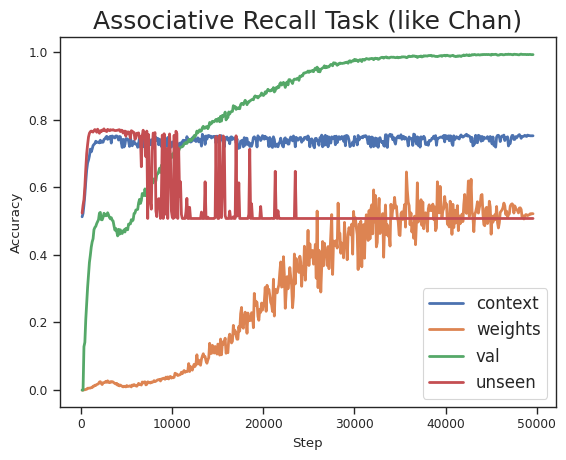

In [75]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for k, v in metrics2.items():
    ax.plot(range(100, 100*len(v)+100, 100), v, label=k)
plt.legend(fontsize=12)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Associative Recall Task (like Chan)', fontsize=18)
plt.show()

In [48]:
metrics1 = train(model, train_loader, optimizer, scheduler, device, num_epochs)
with open('metrics1.json', 'w') as f:
    json.dump(metrics1, f)

Epoch [1/2], Step [1000/25000], Loss: 7.8490
Epoch [1/2], Step [2000/25000], Loss: 7.5772
Epoch [1/2], Step [3000/25000], Loss: 7.2818
Epoch [1/2], Step [4000/25000], Loss: 6.8993
Epoch [1/2], Step [5000/25000], Loss: 6.4499
Epoch [1/2], Step [6000/25000], Loss: 6.0195
Epoch [1/2], Step [7000/25000], Loss: 5.6347
Epoch [1/2], Step [8000/25000], Loss: 5.3033
Epoch [1/2], Step [9000/25000], Loss: 5.0126
Epoch [1/2], Step [10000/25000], Loss: 4.7551
Epoch [1/2], Step [11000/25000], Loss: 4.5245
Epoch [1/2], Step [12000/25000], Loss: 4.3198
Epoch [1/2], Step [13000/25000], Loss: 4.1351
Epoch [1/2], Step [14000/25000], Loss: 3.9634
Epoch [1/2], Step [15000/25000], Loss: 3.8082
Epoch [1/2], Step [16000/25000], Loss: 3.6670
Epoch [1/2], Step [17000/25000], Loss: 3.5364
Epoch [1/2], Step [18000/25000], Loss: 3.4144
Epoch [1/2], Step [19000/25000], Loss: 3.3027
Epoch [1/2], Step [20000/25000], Loss: 3.1973
Epoch [1/2], Step [21000/25000], Loss: 3.0991
Epoch [1/2], Step [22000/25000], Loss: 3.00

In [55]:
## 400,000 examples, 2 epochs, 8 layers, 0.05 amb

metrics1['unseen'] = metrics1['holdout']
del metrics1['holdout']

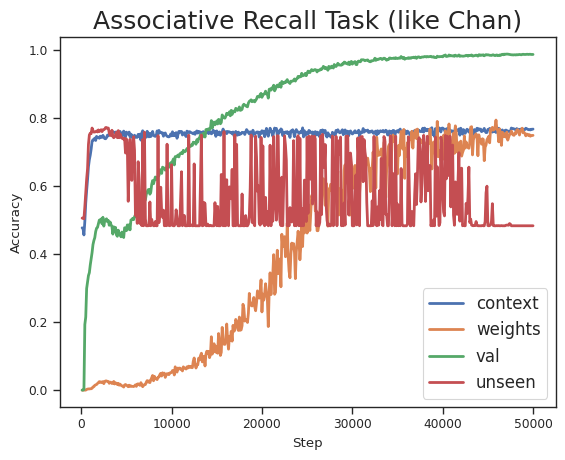

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for k, v in metrics1.items():
    ax.plot(range(100, 100*len(v)+100, 100), v, label=k)
plt.legend(fontsize=12)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Associative Recall Task (like Chan)', fontsize=18)
plt.show()

In [24]:
metrics = train(model, train_loader, optimizer, scheduler, device, num_epochs)
with open('metrics.json', 'w') as f:
    json.dump(metrics, f)

Epoch [1/4], Step [1000/6250], Loss: 7.9349
Epoch [1/4], Step [2000/6250], Loss: 7.5401
Epoch [1/4], Step [3000/6250], Loss: 6.9904
Epoch [1/4], Step [4000/6250], Loss: 6.3846
Epoch [1/4], Step [5000/6250], Loss: 5.8840
Epoch [1/4], Step [6000/6250], Loss: 5.4816
Epoch [1/4], Step [6250/6250], Loss: 5.3886
After Epoch 1:
  Evaluation Accuracy (In-Context Learning): 74.35%
  Evaluation Accuracy (In-Context H Learning): 51.95%
  Evaluation Accuracy (In-Weights Learning): 1.85%
  Evaluation Accuracy Val: 55.20%
Epoch [2/4], Step [1000/6250], Loss: 3.0530
Epoch [2/4], Step [2000/6250], Loss: 2.9241
Epoch [2/4], Step [3000/6250], Loss: 2.8159
Epoch [2/4], Step [4000/6250], Loss: 2.7299
Epoch [2/4], Step [5000/6250], Loss: 2.6470
Epoch [2/4], Step [6000/6250], Loss: 2.5777
Epoch [2/4], Step [6250/6250], Loss: 2.5589
After Epoch 2:
  Evaluation Accuracy (In-Context Learning): 74.45%
  Evaluation Accuracy (In-Context H Learning): 51.95%
  Evaluation Accuracy (In-Weights Learning): 3.80%
  Eval

In [30]:
metrics['unseen'] = metrics['holdout']

## 100,000 examples, 4 epochs, 8 layers, 0.10 amb

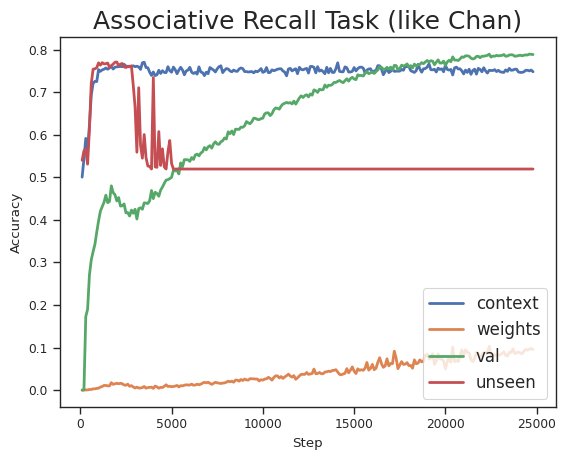

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for k, v in metrics.items():
    ax.plot(range(100, 100*len(v)+100, 100), v, label=k)
plt.legend(fontsize=12)
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Associative Recall Task (like Chan)', fontsize=18)
plt.show()

What worked
0.90, num_examples=200000, epochs=4

In [136]:
idx = 9
inputs = train_dataset[idx]['input_ids'].unsqueeze(0).to(device)
attention_mask = train_dataset[idx]['attention_mask'].unsqueeze(0).to(device)
labels = train_dataset[idx]['labels'].unsqueeze(0).to(device)
preds = model(input_ids=inputs, attention_mask=attention_mask).logits.argmax(axis=-1)

loss_fct(model(input_ids=inputs, attention_mask=attention_mask).logits.view(-1, num_icl_tokens*2+2), labels.view(-1))

tensor(5.3093, device='cuda:0', grad_fn=<NllLossBackward0>)

In [114]:
inputs, labels, model(input_ids=inputs, attention_mask=attention_mask).logits.view(-1, num_icl_tokens*2+2).argmax(axis=-1)

(tensor([[ 62, 162,  31, 131,  74, 174,  63, 163, 201]], device='cuda:0'),
 tensor([[-100, -100, -100, -100, -100, -100,  163, -100, -100]],
        device='cuda:0'),
 tensor([ 62, 162,  31, 131,  74, 174,  63, 163, 201], device='cuda:0'))